**Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.**

In [1]:
from sklearn.datasets import load_diabetes
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def gb_predict(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta
    
#     predictions = np.zeros(X.shape[0])
#     for i, x in enumerate(X):
#         prediction = 0
#         for alg in trees_list:
#             prediction += eta * alg.predict([x])[0]
#         predictions[i] = prediction
        
    predictions = np.array(
        [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
    )

    return predictions

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [3]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y - z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z - y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [4]:
def residual(y, z):
    return - (z - y)

Реализуем функцию обучения градиентного бустинга.

In [5]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [6]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [7]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [8]:
# Число деревьев в ансамбле
n_trees = 10

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

In [9]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, eta):
    train_prediction = gb_predict(X_train, trees, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')
    
    # ---------- ДОБАВИЛА ДЛЯ ВИДИМОСТИ РЕЗУЛЬТАТА----------------
    print(f'разница между ошибками составила: {(mean_squared_error(y_test, test_prediction)) - (mean_squared_error(y_train, train_prediction))}')

In [10]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 1061.7803172372173
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тестовой выборке: 4776.402711126359
разница между ошибками составила: 3714.622393889141


Построим графики зависимости ошибки на обучающей и тестовой выборках от числа итераций.

In [11]:
def get_error_plot (n_trees, train_err, test_err, max_depth): # ---- добавлен max_depth --------
    plt.xlabel('Number trees')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()
    #     ------------------- ИЗМЕНЕНО ниже---------------

    
    plt.xlabel('Depth')
    plt.ylabel('MSE')
    l = list(np.linspace(0, max_depth, len(train_err)))
    plt.plot(l, train_err, label='train error', color='r')
    plt.plot(l, test_err, label='test error', color='g')
    
    plt.legend(loc='upper right')
    plt.show()

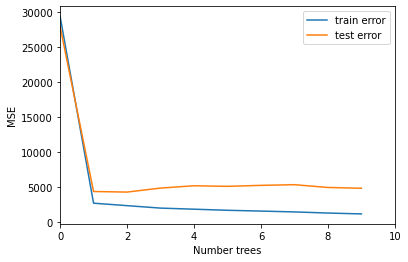

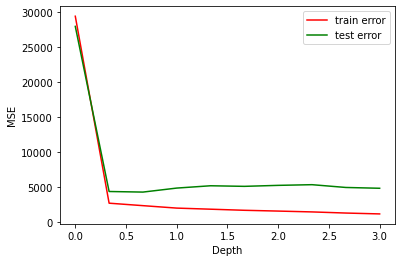

In [12]:
get_error_plot(n_trees, train_errors, test_errors, max_depth)

Такой результат не является удовлетворительным

***Вывод:*** *графики похожи между собой. Слишком большой разрыв между показателями ошибки на тренировочных данных и тестовых данных.*

Увеличим число деревьев.

In [13]:
%%time
n_trees = 50

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

Wall time: 33.7 s


In [14]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 58.43855381164796
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 1 на тестовой выборке: 5785.749391671108
разница между ошибками составила: 5727.310837859461


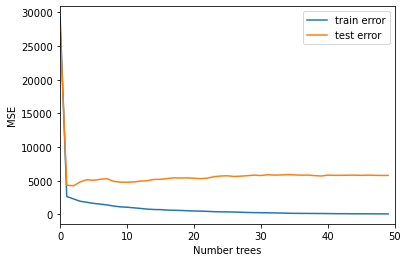

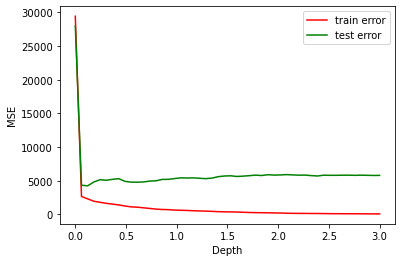

In [15]:
get_error_plot(n_trees, train_errors, test_errors, max_depth)

***Вывод:*** *графики также похожи между собой. Разрыв между показателями ошибки на тренировочных данных и тестовых данных увеличился, значит нужно менять шаг.*

Теперь попробуем уменьшить шаг.

In [16]:
%%time
eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

Wall time: 33.6 s


In [17]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 1345.4821783646057
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 3606.7751277332873
разница между ошибками составила: 2261.2929493686815


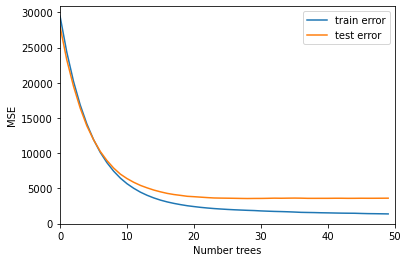

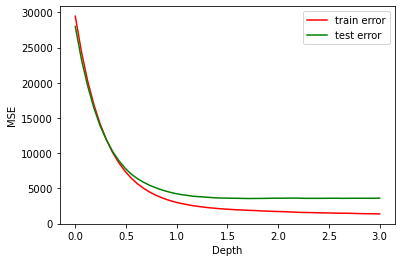

In [18]:
get_error_plot(n_trees, train_errors, test_errors, max_depth)

Видим, что качество обучения улучшается.

***Вывод:*** *графики похожи между собой. разрыв между показателями ошибки на тренировочных данных и тестовых данных, заметно сократился, но остается достаточно большим. На графике видим, что при увеличении глубины дерева ошибка снижается: до глубины 1 - снижение ошибки активное, а с 1 до 3 плавное снижение*

Уменьшим шаг до 0.01.

In [19]:
%%time
eta = 0.01

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

Wall time: 33.6 s


In [20]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.01 на тренировочной выборке: 12387.48511690918
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.01 на тестовой выборке: 12384.078147391861
разница между ошибками составила: -3.40696951731843


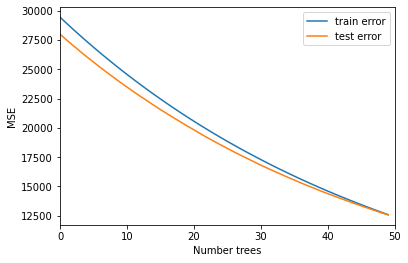

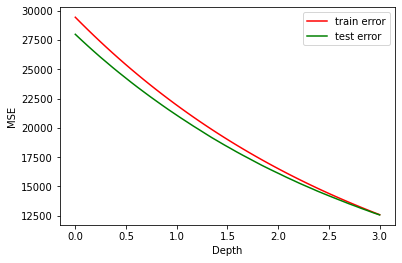

In [21]:
get_error_plot(n_trees, train_errors, test_errors, max_depth)

При таком размере шага алгоритм сходится, но ему для достижения удовлетворительных показателей требуется большее количество итераций.

***Вывод:*** *графики опять же похожи между собой. Разница между ошибками минимальная*

Вернемся к шагу 0.1 и попробуем увеличить глубину деревьев

In [22]:
%%time
eta = 0.1
max_depth = 5

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

Wall time: 33.7 s


In [23]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)

Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 299.9418515044271
Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 4036.5304662024982
разница между ошибками составила: 3736.588614698071


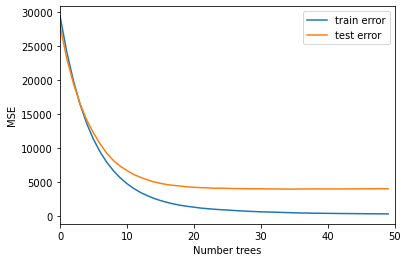

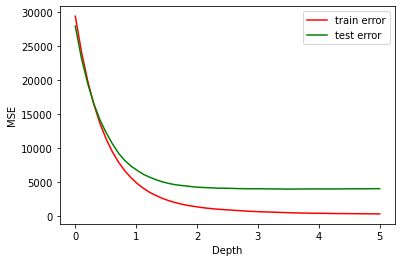

In [24]:
get_error_plot(n_trees, train_errors, test_errors, max_depth)

***Вывод:*** *графики опять же похожи между собой. Ошибка на тренировочной выборке снизилась, а на тестовой стала чуть больше, что говорит о переобучении. На графике с глубиной дерева можно заметить, что ошибка после глубины 4 не меняется и остается прежней*

Ошибка на обучающей выборке упала, а на тестовой несколько поднялась, то есть в данном случае можем говорить о появлении переобучения.

В целом, тут мы показали, что варьируя параметры обучения градиентного бустинга можно добиваться различного уровня точности модели.

Существуют различные реализации градиентного бустинга, и одна из самых популярных и широко используемых - XGBoost (в Python содержится в библиотеке с аналогичным названием). С этой реализацией можно ознакомиться в дополнительных материалах.

In [34]:
# -------------- ДОБАВИЛА ниже еще графики с изменением параметров----------

In [31]:
%%time
eta = 0.01
max_depth = 5
n_trees = 60

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

Wall time: 48.7 s


In [32]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)

Ошибка алгоритма из 60 деревьев глубиной 5     с шагом 0.01 на тренировочной выборке: 9893.419296556714
Ошибка алгоритма из 60 деревьев глубиной 5     с шагом 0.01 на тестовой выборке: 11051.40004345314
разница между ошибками составила: 1157.9807468964264


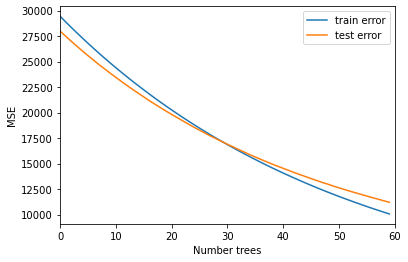

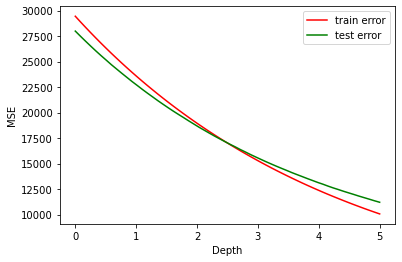

In [33]:
get_error_plot(n_trees, train_errors, test_errors, max_depth)

***Вывод:*** *похоже что произошло переобучение, т.к. в конце графиков видим, что ошибка на тестовых данных увеличивается*